In [89]:
import pandas as pd
import numpy as np
import math
import sys
import os
import datetime
from hmmlearn import hmm
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

pre_path = "./data/"

# Load data

In [35]:
pre_file_list = os.listdir(pre_path)
data_df = pd.DataFrame()
col_list = []
for file in pre_file_list:
    #print(file)
    tmp_path = pre_path + file
    coin_type = file.split("USDT")[0]
    tmp_df = pd.read_csv(tmp_path)
    if len(col_list) == 0 and "close" in tmp_df.columns:
        col_list = tmp_df.columns
    out = [i for i, j in zip(col_list, tmp_df.columns) if i != j]
    if len(out) != 0:
        tmp_df = pd.read_csv(tmp_path,header = None)
        tmp_df.columns = col_list
    tmp_df["coin_type"] = coin_type
    tmp_df['open_time'] = tmp_df['open_time'].apply(lambda x: x//1000)
    tmp_df['open_time'] = pd.to_datetime(tmp_df['open_time'],unit='s')
    tmp_df['close_time'] = tmp_df['close_time'].apply(lambda x: x//1000)
    tmp_df['close_time'] = pd.to_datetime(tmp_df['close_time'],unit='s')
    data_df = pd.concat([data_df,tmp_df],axis = 0, ignore_index=True)

data_df = data_df.sort_values(by=['open_time',"coin_type"], ascending=True)
data_df = data_df.reset_index(drop = True)
display(data_df)

,open_time,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,ignore,coin_type
0,2022-01-01 00:00:00,1.30770,1.33280,1.30760,1.32910,1.461367e+07,2022-01-01 00:59:59,1.930024e+07,29050,7.568545e+06,9.993614e+06,0,ADA
1,2022-01-01 00:00:00,511.55000,517.85000,511.43000,517.42000,2.932202e+04,2022-01-01 00:59:59,1.509610e+07,22736,1.591227e+04,8.192958e+06,0,BNB
2,2022-01-01 00:00:00,46210.57000,46729.73000,46210.55000,46650.01000,8.957465e+03,2022-01-01 00:59:59,4.164448e+08,91267,4.777701e+03,2.221296e+08,0,BTC
3,2022-01-01 00:00:00,3676.01000,3730.00000,3676.01000,3721.67000,4.583592e+04,2022-01-01 00:59:59,1.698204e+08,67207,2.553325e+04,9.462762e+07,0,ETH
4,2022-01-01 00:00:00,0.45057,0.45797,0.45002,0.45756,3.289705e+07,2022-01-01 00:59:59,1.494042e+07,30227,1.714832e+07,7.788349e+06,0,GALA
...,...,...,...,...,...,...,...,...,...,...,...,...,...
165471,2023-11-30 23:00:00,0.26040,0.26210,0.25980,0.26190,1.004176e+07,2023-11-30 23:59:59,2.621476e+06,7398,5.443095e+06,1.421194e+06,0,GMT
165472,2023-11-30 23:00:00,14.31900,14.41000,14.28700,14.40700,4.770194e+05,2023-11-30 23:59:59,6.848692e+06,16444,2.734755e+05,3.927484e+06,0,LINK
165473,2023-11-30 23:00:00,0.76070,0.76330,0.75760,0.76260,1.260543e+07,2023-11-30 23:59:59,9.591372e+06,18852,6.195142e+06,4.714729e+06,0,MATIC
165474,2023-11-30 23:00:00,59.28400,59.30900,58.95300,59.30900,8.111330e+05,2023-11-30 23:59:59,4.799254e+07,54419,4.226510e+05,2.501009e+07,0,SOL


# HMM

## single coin strategy

K=2 → Validation Sharpe = -1.54
K=3 → Validation Sharpe = 2.03
K=4 → Validation Sharpe = 1.41

Best K on validation = 3, Sharpe = 2.03

Test Sharpe (K=3) = 2.05


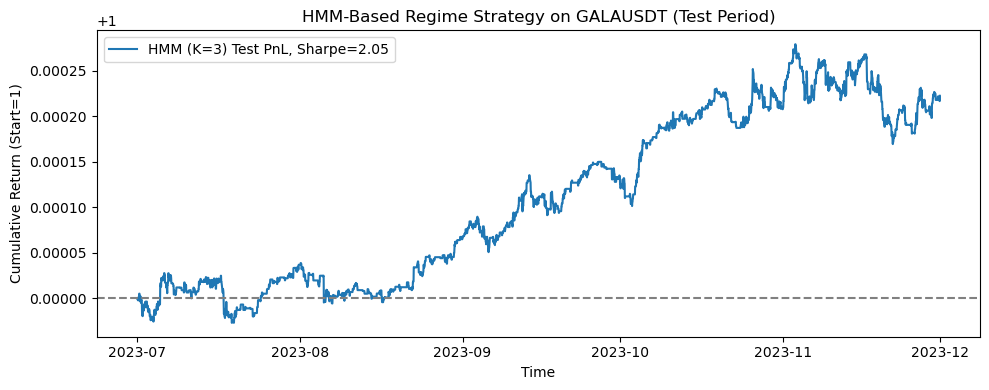

In [67]:

# 1) FILTER TO BTCUSDT AND SORT
df = data_df[data_df['coin_type'] == 'GALA'].copy()
df['open_time'] = pd.to_datetime(df['open_time'])
df = df.sort_values('open_time').reset_index(drop=True)

# 2) FEATURE ENGINEERING
# 2.1 Hourly return r_t
df['r'] = df['close'].pct_change()

# 2.2 Rolling 24h volatility: vol24_t
df['vol24'] = df['r'].rolling(window=24, min_periods=24).std()

# 2.3 Lagged returns r_{t-1}, r_{t-2}, r_{t-3}
df['r_lag1'] = df['r'].shift(1)
df['r_lag2'] = df['r'].shift(2)
df['r_lag3'] = df['r'].shift(3)

# 2.4 Hourly log-volume change: Δ ln(vol)_t
df['log_vol'] = np.log(df['volume'].replace(0, np.nan))
df['vol_chg'] = df['log_vol'].diff()

# 2.5 RSI(14)
delta = df['close'].diff()
gain = (delta.clip(lower=0)).rolling(window=14, min_periods=14).mean()
loss = (-delta.clip(upper=0)).rolling(window=14, min_periods=14).mean()
rs = gain / loss
df['RSI14'] = 100 - 100 / (1 + rs)

# 2.6 Forward return (label)
df['r_fwd'] = df['r'].shift(-1)

# 2.7 Drop rows with any NaN among the features or label
feature_cols = ['r', 'vol24', 'r_lag1', 'r_lag2', 'r_lag3', 'vol_chg', 'RSI14']
df = df.dropna(subset=feature_cols + ['r_fwd']).reset_index(drop=True)

# 3) SPLIT INTO TRAIN / VAL / TEST
train_end = pd.to_datetime("2022-12-31 23:00:00")
val_end   = pd.to_datetime("2023-06-30 23:00:00")

mask_train = df['open_time'] <= train_end
mask_val   = (df['open_time'] > train_end) & (df['open_time'] <= val_end)
mask_test  = df['open_time'] > val_end

df_train = df.loc[mask_train].copy().reset_index(drop=True)
df_val   = df.loc[mask_val].copy().reset_index(drop=True)
df_test  = df.loc[mask_test].copy().reset_index(drop=True)

# 4) SCALE FEATURES BASED ON TRAIN ONLY
X_train = df_train[feature_cols].values
X_val   = df_val[feature_cols].values
X_test  = df_test[feature_cols].values

scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

# 5) SHARPE HELPER
def compute_sharpe(signal, returns):
    pnl = signal.shift(1).fillna(0) * returns
    avg = pnl.mean()
    std = pnl.std(ddof=0)
    return (avg / std) * np.sqrt(8760) if std != 0 and not np.isnan(std) else np.nan

# 6) HMM GRID SEARCH OVER K = 2, 3, 4
best_K = None
best_val_sharpe = -np.inf
best_hmm = None
best_state_info = None  # stores (state_weights, mapping, etc.)

for K in [2, 3, 4]:
    # 6.1) FIT HMM ON TRAINING FEATURES
    model = hmm.GaussianHMM(n_components=K, covariance_type='full', n_iter=200, random_state=42)
    model.fit(X_train_s)
    
    # 6.2) COMPUTE POSTERIOR ON TRAIN, THEN WEIGHTED-AVERAGE FORWARD-RETURNS
    post_train = model.predict_proba(X_train_s)  # shape = (N_train, K)
    # Weighted average forward return per state:
    #   wAR_i = sum_t [ post_train[t,i] * r_fwd[t] ] / sum_t [ post_train[t,i] ]
    weighted_avgs = {}
    for i in range(K):
        weights_i = post_train[:, i]
        numerator = (weights_i * df_train['r_fwd'].values).sum()
        denom = weights_i.sum()
        wavg = numerator / denom if denom > 0 else 0.0
        weighted_avgs[i] = wavg
    
    # 6.3) ON VALIDATION, COMPUTE POSTERIOR & “CONFIDENT” RAW STATE (threshold 0.8)
    post_val = model.predict_proba(X_val_s)  # (N_val, K)
    raw_state_val = np.argmax(post_val, axis=1)
    raw_maxp_val  = post_val.max(axis=1)
    raw_conf_val  = np.where(raw_maxp_val >= 0.8, raw_state_val, -1)  # -1 = no confident state
    
    # 6.4) SMOOTH VIA “2-OF-3” SLIDING-WINDOW DWELL RULE
    N_val = len(raw_conf_val)
    smoothed_val = np.full(N_val, -1, dtype=int)
    current = raw_conf_val[0]
    smoothed_val[0] = current
    for t in range(1, N_val):
        rs = raw_conf_val[t]
        if rs == current:
            smoothed_val[t] = current
        else:
            # Check if rs appears ≥ 2 times in {raw_conf_val[t], raw_conf_val[t+1], raw_conf_val[t+2]}
            # If t+2 >= N_val, only consider up to available indices.
            window = raw_conf_val[t : min(N_val, t+3)]
            if rs != -1 and np.count_nonzero(window == rs) >= 2:
                current = rs
            # Otherwise, stay in current
            smoothed_val[t] = current
    
    # 6.5) COMPUTE VALIDATION SIGNAL: SIGNAL_VAL[t] = weighted_avgs[state] (or 0 if state=-1)
    sig_val = pd.Series(0.0, index=df_val.index)
    for t, s in enumerate(smoothed_val):
        sig_val.iloc[t] = weighted_avgs[s] if s in weighted_avgs else 0.0
    
    # 6.6) COMPUTE VALIDATION SHARPE
    sharpe_val = compute_sharpe(sig_val, df_val['r'])
    print(f"K={K} → Validation Sharpe = {sharpe_val:.2f}")
    
    if sharpe_val > best_val_sharpe:
        best_val_sharpe = sharpe_val
        best_K = K
        best_hmm = model
        best_state_info = {
            'weighted_avgs': weighted_avgs.copy()
        }

print(f"\nBest K on validation = {best_K}, Sharpe = {best_val_sharpe:.2f}")

# 7) REFIT BEST HMM ON TRAIN+VAL, RECOMPUTE WEIGHTED-AVG FORWARD-RETURNS
df_trainval = pd.concat([df_train, df_val]).reset_index(drop=True)
X_trainval = df_trainval[feature_cols].values
X_trainval_s = scaler.transform(X_trainval)

hmm_final = hmm.GaussianHMM(n_components=best_K, covariance_type='full', n_iter=200, random_state=42)
hmm_final.fit(X_trainval_s)

post_tv = hmm_final.predict_proba(X_trainval_s)
weighted_avgs_tv = {}
for i in range(best_K):
    w_i = post_tv[:, i]
    numerator = (w_i * df_trainval['r_fwd'].values).sum()
    denom = w_i.sum()
    weighted_avgs_tv[i] = numerator / denom if denom > 0 else 0.0

# 8) ON TEST, APPLY POSTERIOR, THRESHOLD @ 0.8, THEN “2-OF-3” DWELL
post_test = hmm_final.predict_proba(X_test_s)  # (N_test, best_K)
raw_state_test = np.argmax(post_test, axis=1)
raw_maxp_test  = post_test.max(axis=1)
raw_conf_test  = np.where(raw_maxp_test >= 0.8, raw_state_test, -1)

N_test = len(raw_conf_test)
smoothed_test = np.full(N_test, -1, dtype=int)
current = raw_conf_test[0]
smoothed_test[0] = current
for t in range(1, N_test):
    rs = raw_conf_test[t]
    if rs == current:
        smoothed_test[t] = current
    else:
        window = raw_conf_test[t : min(N_test, t+3)]
        if rs != -1 and np.count_nonzero(window == rs) >= 2:
            current = rs
        smoothed_test[t] = current

# 9) COMPUTE TEST SIGNAL: SIGNAL_TEST[t] = weighted_avgs_tv[state] (or 0 if -1)
sig_test = pd.Series(0.0, index=df_test.index)
for t, s in enumerate(smoothed_test):
    sig_test.iloc[t] = weighted_avgs_tv[s] if s in weighted_avgs_tv else 0.0

# 10) COMPUTE TEST SHARPE & CUMULATIVE PNL
sharpe_test = compute_sharpe(sig_test, df_test['r'])
pnl_test = sig_test.shift(1).fillna(0) * df_test['r']
cum_test = (1 + pnl_test.fillna(0)).cumprod()

print(f"\nTest Sharpe (K={best_K}) = {sharpe_test:.2f}")

# 11) PLOT CUMULATIVE RETURN
plt.figure(figsize=(10, 4))
plt.plot(df_test['open_time'], cum_test.values,
         label=f"HMM (K={best_K}) Test PnL, Sharpe={sharpe_test:.2f}")
plt.axhline(1.0, linestyle='--', color='gray')
plt.title("HMM‐Based Regime Strategy on GALAUSDT (Test Period)")
plt.xlabel("Time")
plt.ylabel("Cumulative Return (Start=1)")
plt.legend()
plt.tight_layout()
plt.show()


## Multiple coins strategy

K=2 → Validation Portfolio Sharpe = -0.82
K=3 → Validation Portfolio Sharpe = -1.72
K=4 → Validation Portfolio Sharpe = 1.39

Chosen K on validation: 4, Sharpe=1.39

Test Portfolio Sharpe (K=4) = 2.22


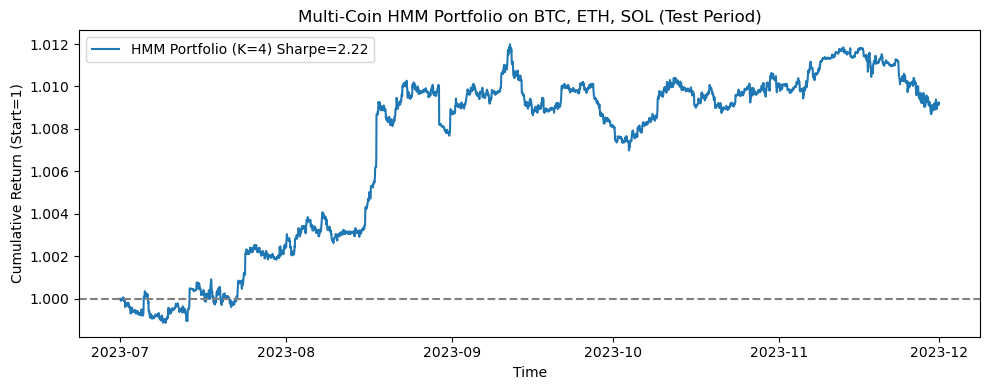

In [85]:
universe = list(data_df['coin_type'].unique())
df_univ = data_df[data_df['coin_type'].isin(universe)].copy()
df_univ['open_time'] = pd.to_datetime(df_univ['open_time'])
df_univ = df_univ.sort_values(['coin_type','open_time']).reset_index(drop=True)

# 2) PIVOT & FEATURE ENGINEERING PER COIN
# (a) Pivot close and volume so we have a DataFrame of shape (T, len(universe)):
close_df  = df_univ.pivot(index='open_time', columns='coin_type', values='close')
volume_df = df_univ.pivot(index='open_time', columns='coin_type', values='volume')

# (b) Compute per-coin features
features = []
for c in universe:
    tmp = pd.DataFrame(index=close_df.index)
    tmp['r_' + c]      = close_df[c].pct_change(fill_method=None)
    tmp['vol24_' + c]  = tmp['r_' + c].rolling(window=24, min_periods=24).std()
    tmp['r_lag1_' + c] = tmp['r_' + c].shift(1)
    tmp['r_lag2_' + c] = tmp['r_' + c].shift(2)
    tmp['r_lag3_' + c] = tmp['r_' + c].shift(3)
    tmp['log_vol_' + c]= np.log(volume_df[c].replace(0, np.nan))
    tmp['vol_chg_' + c]= tmp['log_vol_' + c].diff()
    # RSI(14)
    price = close_df[c]
    delta = price.diff()
    gain  = (delta.clip(lower=0)).rolling(window=14, min_periods=14).mean()
    loss  = (-delta.clip(upper=0)).rolling(window=14, min_periods=14).mean()
    rs    = gain / loss
    tmp['RSI14_' + c] = 100 - 100/(1+rs)
    # forward return
    tmp['r_fwd_' + c] = tmp['r_' + c].shift(-1)
    features.append(tmp)

# (c) Combine features across all coins into one wide DataFrame
feat_df = pd.concat(features, axis=1)

# Drop any row with NaN in ANY feature
feat_df = feat_df.dropna().reset_index()

# 3) SPLIT INTO TRAIN / VALIDATION / TEST
# ─────────────────────────────────────────────────────────────────────────────
train_end = pd.to_datetime("2022-12-31 23:00:00")
val_end   = pd.to_datetime("2023-06-30 23:00:00")

mask_train = feat_df['open_time'] <= train_end
mask_val   = (feat_df['open_time'] > train_end) & (feat_df['open_time'] <= val_end)
mask_test  = feat_df['open_time'] > val_end

df_train = feat_df.loc[mask_train].reset_index(drop=True)
df_val   = feat_df.loc[mask_val].reset_index(drop=True)
df_test  = feat_df.loc[mask_test].reset_index(drop=True)

# 4) BUILD FEATURE MATRICES & SCALE
# ─────────────────────────────────────────────────────────────────────────────
# Feature columns are every column that starts with one of our prefixes (but NOT r_fwd_*).
all_feats = [col for col in feat_df.columns 
             if col.startswith(('r_','vol24_','r_lag','vol_chg_','RSI14_')) and not col.startswith('r_fwd_')]

X_train = df_train[all_feats].values
X_val   = df_val[all_feats].values
X_test  = df_test[all_feats].values

scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

# 5) SHARPE HELPERS & UTILITY
# ─────────────────────────────────────────────────────────────────────────────
# Given a Pandas Series `signal` of shape (N,) and returns_dict mapping coin→returns Series,
# compute portfolio PnL_t = sum_c signal[t-1] * r_c(t) for each hour t.
def compute_portfolio_sharpe(signal, returns_dict):
    # signal: pd.Series indexed like df_test, same length N
    # returns_dict[c]: pd.Series of returns for coin c, also length N
    pnl = np.zeros(len(signal))
    sig_vals = signal.values
    for t in range(1, len(signal)):
        for c in universe:
            pnl[t] += sig_vals[t-1] * returns_dict[c].iloc[t]
    pnl = pd.Series(pnl, index=signal.index)
    avg = pnl.mean()
    std = pnl.std(ddof=0)
    return (avg / std)*np.sqrt(8760) if std != 0 and not np.isnan(std) else np.nan, pnl, (1+pnl).cumprod()

# 6) GRID SEARCH OVER K = 2,3,4 ON TRAIN, VALIDATE ON VAL
# ─────────────────────────────────────────────────────────────────────────────
best_K = None
best_val_sharpe = -np.inf
best_hmm = None
best_state_info = None  # will store weighted_avgs_per_state_per_coin

for K in [2, 3, 4]:
    # 6.1) Fit HMM on TRAIN
    model = hmm.GaussianHMM(n_components=K, covariance_type='full', n_iter=200, random_state=42)
    model.fit(X_train_s)
    
    # 6.2) Compute posterior on TRAIN: shape=(N_train, K)
    post_train = model.predict_proba(X_train_s)
    
    # 6.3) For each state i and each coin c, compute a weighted average forward return:
    #      wavg_{i,c} = sum_{t in TRAIN} [ post_train[t,i] * r_fwd_c(t) ] / sum_{t in TRAIN} post_train[t,i]
    weighted_avgs = {i: {} for i in range(K)}
    for i in range(K):
        w_i = post_train[:, i]
        denom = w_i.sum()
        for c in universe:
            r_fwd_c = df_train[f'r_fwd_{c}'].values
            numerator = (w_i * r_fwd_c).sum()
            weighted_avgs[i][c] = numerator/denom if denom>0 else 0.0
    
    # 6.4) On VALIDATION, compute posterior & “confident” raw states (threshold 0.8)
    post_val = model.predict_proba(X_val_s)  # (N_val, K)
    raw_state_val = np.argmax(post_val, axis=1)
    raw_maxp_val  = post_val.max(axis=1)
    raw_conf_val  = np.where(raw_maxp_val >= 0.8, raw_state_val, -1)
    
    # 6.5) Smooth via “2-of-3” dwell rule
    N_val = len(raw_conf_val)
    smoothed_val = np.full(N_val, -1, dtype=int)
    current = raw_conf_val[0]
    smoothed_val[0] = current
    for t in range(1, N_val):
        rs = raw_conf_val[t]
        if rs == current:
            smoothed_val[t] = current
        else:
            window = raw_conf_val[t : min(N_val, t+3)]
            if rs != -1 and np.count_nonzero(window == rs) >= 2:
                current = rs
            smoothed_val[t] = current
    
    # 6.6) Build a VALIDATION‐PERIOD “portfolio signal” at each hour:
    #      signal_val[t] = sum_c weighted_avgs[state_t][c], clipped to ±1
    #      (then we’ll fill or clip to manage leverage)
    sig_val = pd.Series(0.0, index=df_val.index)
    for t, s in enumerate(smoothed_val):
        if s == -1:
            sig_val.iloc[t] = 0.0
        else:
            # sum up expected returns across coins for that state
            val = sum(weighted_avgs[s][c] for c in universe)
            # clip to [-1, +1] so we never exceed 100% net position
            sig_val.iloc[t] = np.sign(val) * min(abs(val), 1.0)
    
    # 6.7) Build a returns_dict for VALIDATION
    returns_val = {c: df_val[f'r_{c}'] for c in universe}
    sharpe_val, pnl_val, cum_val = compute_portfolio_sharpe(sig_val, returns_val)
    
    print(f"K={K} → Validation Portfolio Sharpe = {sharpe_val:.2f}")
    if sharpe_val > best_val_sharpe:
        best_val_sharpe = sharpe_val
        best_K = K
        best_hmm = model
        best_state_info = {
            'weighted_avgs': {i: weighted_avgs[i].copy() for i in range(K)}
        }

print(f"\nChosen K on validation: {best_K}, Sharpe={best_val_sharpe:.2f}\n")

# 7) RE-FIT HMM ON TRAIN+VAL AND RE-COMPUTE STATE→EXPECTED RETURNS
# ─────────────────────────────────────────────────────────────────────────────
df_trainval = pd.concat([df_train, df_val]).reset_index(drop=True)
X_trainval = df_trainval[all_feats].values
X_trainval_s = scaler.transform(X_trainval)

hmm_final = hmm.GaussianHMM(n_components=best_K, covariance_type='full', n_iter=200, random_state=42)
hmm_final.fit(X_trainval_s)

post_tv = hmm_final.predict_proba(X_trainval_s)
weighted_avgs_tv = {i: {} for i in range(best_K)}
for i in range(best_K):
    w_i = post_tv[:, i]
    denom = w_i.sum()
    for c in universe:
        r_fwd_c = df_trainval[f'r_fwd_{c}'].values
        numerator = (w_i * r_fwd_c).sum()
        weighted_avgs_tv[i][c] = numerator/denom if denom>0 else 0.0

# 8) APPLY TO TEST: posterior + threshold + dwell
post_test = hmm_final.predict_proba(X_test_s)  # (N_test, best_K)
raw_state_test = np.argmax(post_test, axis=1)
raw_maxp_test  = post_test.max(axis=1)
raw_conf_test  = np.where(raw_maxp_test >= 0.8, raw_state_test, -1)

N_test = len(raw_conf_test)
smoothed_test = np.full(N_test, -1, dtype=int)
current = raw_conf_test[0]
smoothed_test[0] = current
for t in range(1, N_test):
    rs = raw_conf_test[t]
    if rs == current:
        smoothed_test[t] = current
    else:
        window = raw_conf_test[t : min(N_test, t+3)]
        if rs != -1 and np.count_nonzero(window == rs) >= 2:
            current = rs
        smoothed_test[t] = current

# 9) BUILD TEST SIGNAL: sum of weighted_avgs_tv across coins, clipped to ±1
sig_test = pd.Series(0.0, index=df_test.index)
for t, s in enumerate(smoothed_test):
    if s == -1:
        sig_test.iloc[t] = 0.0
    else:
        val = sum(weighted_avgs_tv[s][c] for c in universe)
        sig_test.iloc[t] = np.sign(val) * min(abs(val), 1.0)

# 10) COMPUTE TEST SHARPE & CUM PNL
returns_test = {c: df_test[f'r_{c}'] for c in universe}
sharpe_test, pnl_test, cum_test = compute_portfolio_sharpe(sig_test, returns_test)

print(f"Test Portfolio Sharpe (K={best_K}) = {sharpe_test:.2f}")

# 11) PLOT TEST CUMULATIVE RETURN
plt.figure(figsize=(10, 4))
plt.plot(df_test['open_time'], cum_test.values, label=f"HMM Portfolio (K={best_K}) Sharpe={sharpe_test:.2f}")
plt.axhline(1.0, linestyle='--', color='gray')
plt.title("Multi‐Coin HMM Portfolio on BTC, ETH, SOL (Test Period)")
plt.xlabel("Time")
plt.ylabel("Cumulative Return (Start=1)")
plt.legend()
plt.tight_layout()
plt.show()


# Kalman filter

## Only one pair strategy

C:\Users\g3055\AppData\Local\Temp\ipykernel_14696\2633350689.py:94: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pnl[t] = -returns_btc[t] + betas[t-1] * returns_eth[t]
C:\Users\g3055\AppData\Local\Temp\ipykernel_14696\2633350689.py:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pnl[t] = returns_btc[t] - betas[t-1] * returns_eth[t]


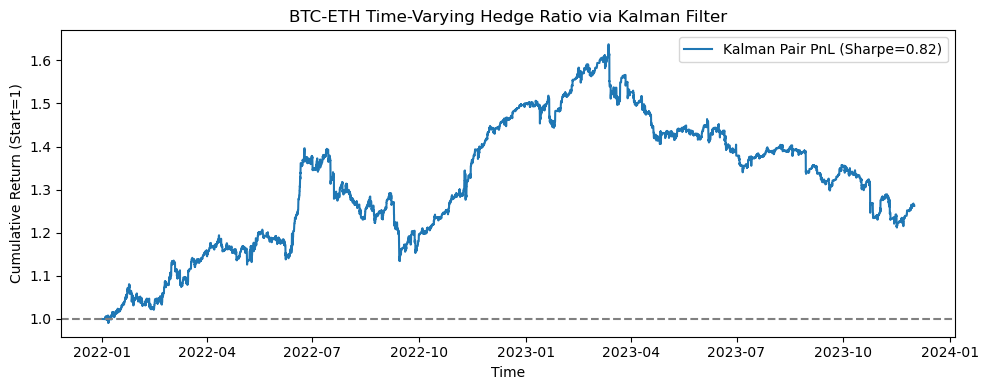

In [87]:
c1= "BTC"
c2= "ETH"

# 1) Pivot to get hourly close prices for BTC and ETH
price_df = data_df.pivot(index='open_time', columns='coin_type', values='close')
pair = [c1, c2]
df_pair = price_df[pair].dropna()

# 2) Build log‐prices
log_btc = np.log(df_pair[c1].values)  # (T,)
log_eth = np.log(df_pair[c2].values)  # (T,)
T = len(log_btc)

# 3) Construct the time‐varying observation_matrices array H[t] = [[1, log_eth_t]]
#    Shape must be (T, 1, 2) because observation vector is 1×1 (just log(BTC)), 
#    and state vector is 2×1 ([alpha, beta]).
H = np.zeros((T, 1, 2))
for t in range(T):
    H[t, 0, 0] = 1.0
    H[t, 0, 1] = log_eth[t]

# 4) Define all state‐space parameters with consistent shapes:
transition_matrix      = np.eye(2)           # 2×2 identity
initial_state_mean     = np.array([0.0, 1.0])  # shape (2,)
initial_state_covariance = np.eye(2) * 1e4    # shape (2,2)
transition_covariance  = np.eye(2) * 0.001     # shape (2,2)
observation_covariance = np.array([[0.01]])    # shape (1,1)

# 5) Instantiate and run the Kalman Filter
kf = KalmanFilter(
    transition_matrices      = transition_matrix,        # (2,2)
    observation_matrices     = H,                        # (T,1,2)
    initial_state_mean       = initial_state_mean,       # (2,)
    initial_state_covariance = initial_state_covariance, # (2,2)
    transition_covariance    = transition_covariance,    # (2,2)
    observation_covariance   = observation_covariance    # (1,1)
)

# 6) Filter on observed log(BTC) as a 2D array of shape (T, 1)
state_means, state_covs = kf.filter(log_btc.reshape(-1, 1))
# state_means has shape (T, 2)  → columns are [alpha_t, beta_t]

alphas = state_means[:, 0]  # (T,)
betas  = state_means[:, 1]  # (T,)

# 7) Compute time‐varying spread: S_t = log_btc - alpha_t - beta_t * log_eth
spread = log_btc - alphas - betas * log_eth

# 8) Z‐score the spread over a rolling 48‐hour window
spread_series = pd.Series(spread, index=df_pair.index)
roll_mean = spread_series.rolling(window=48, min_periods=48).mean()
roll_std  = spread_series.rolling(window=48, min_periods=48).std()
zscore    = (spread_series - roll_mean) / roll_std

# 9) Generate mean‐reversion signals on zscore:
#    - If z > +1  → short spread
#    - If z < -1  → long spread
#    - Exit (0) when |z| ≤ 0
sig = pd.Series(0, index=zscore.index)
position = 0
for t in range(len(zscore)):
    z = zscore.iloc[t]
    if np.isnan(z):
        continue
    if position == 0:
        if z > 1:
            position = -1   # short spread
        elif z < -1:
            position = 1    # long spread
    elif position == 1 and z >= 0:
        position = 0
    elif position == -1 and z <= 0:
        position = 0
    sig.iloc[t] = position

# 10) Backtest PnL on the pair
returns_btc = df_pair[c1].pct_change().fillna(0)
returns_eth = df_pair[c2].pct_change().fillna(0)

pnl = np.zeros(T)
prev_pos = 0
for t in range(1, T):
    pos = sig.iloc[t]
    if prev_pos == 1:
        pnl[t] = returns_btc[t] - betas[t-1] * returns_eth[t]
    elif prev_pos == -1:
        pnl[t] = -returns_btc[t] + betas[t-1] * returns_eth[t]
    else:
        pnl[t] = 0.0
    prev_pos = pos

cum_pnl = np.cumprod(1 + pnl)  # cumulative return assuming starting at 1
sharpe = (np.mean(pnl) / np.std(pnl, ddof=0)) * np.sqrt(8760)

# 11) Plot the results
plt.figure(figsize=(10, 4))
plt.plot(df_pair.index, cum_pnl, label=f"Kalman Pair PnL (Sharpe={sharpe:.2f})")
plt.axhline(1.0, color='gray', linestyle='--')
plt.title(f"{c1}‐{c2} Time‐Varying Hedge Ratio via Kalman Filter")
plt.xlabel("Time")
plt.ylabel("Cumulative Return (Start=1)")
plt.legend()
plt.tight_layout()
plt.show()


## Multi asset Kalman filter strategy

Model is not converging.  Current: 17735.717775309913 is not greater than 17735.78125542219. Delta is -0.06348011227601091


Test Sharpe (Multi‐Asset Kalman + Residual HMM) = 4.62


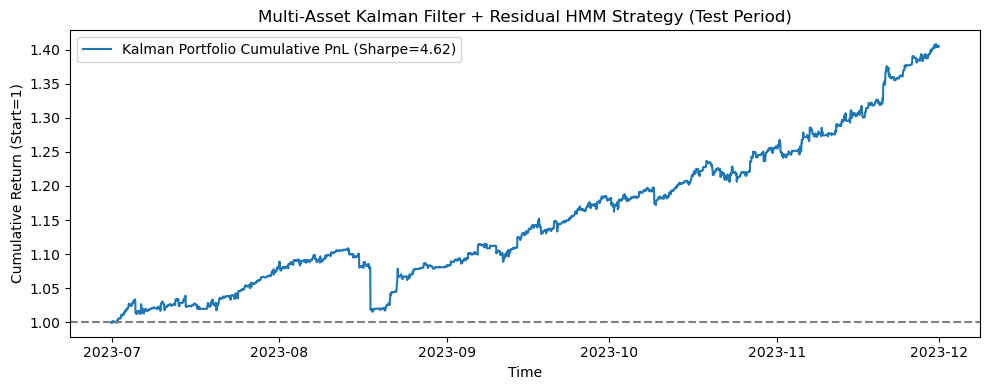

In [127]:
# 1) PIVOT log-prices and compute returns
data_df['open_time'] = pd.to_datetime(data_df['open_time'])
df_all = data_df.pivot(index='open_time', columns='coin_type', values='close').dropna()
coins = universe
log_prices = np.log(df_all[coins].values)   # shape (T, 10)
returns = df_all[coins].pct_change().fillna(0)  # (T,10), for PnL

# 2) DEFINE TRAIN / VAL / TEST SPLITS
train_end = pd.to_datetime("2022-12-31 23:00:00")
val_end   = pd.to_datetime("2023-06-30 23:00:00")

times = df_all.index
mask_train = times <= train_end
mask_val   = (times > train_end) & (times <= val_end)
mask_test  = times > val_end

log_train = log_prices[mask_train]
log_val   = log_prices[mask_val]
log_test  = log_prices[mask_test]

# 3) INITIAL KALMAN FILTER (static Q, R) ON FULL SERIES TO GET INITIAL STATES
T_total = len(log_prices)
n_assets = len(coins)

# Build observation matrices H_t = I_{10×10}, repeated
H = np.tile(np.eye(n_assets), (T_total, 1, 1))  # shape (T, 10, 10)

# Choose static Q, R initial values
Q_init = np.eye(n_assets) * 1e-4
R_init = np.eye(n_assets) * 1e-3

kf_initial = KalmanFilter(
    transition_matrices      = np.eye(n_assets),
    observation_matrices     = H,
    initial_state_mean       = log_prices[0],            # start latent = first log-price
    initial_state_covariance = np.eye(n_assets) * 1e4,
    transition_covariance    = Q_init,
    observation_covariance   = R_init
)

state_means_init, state_covs_init = kf_initial.filter(log_prices)

# 4) COMPUTE RESIDUALS AND ROLLING VARIANCE → time-varying R
residuals = log_prices - state_means_init  # shape (T,10)
resid_df = pd.DataFrame(residuals, index=times, columns=coins)

# Rolling variance of residuals over 48-hour window
roll_var = resid_df.rolling(window=48, min_periods=48).var().bfill() # (T,10)

# Build time-varying R array: (T, 10, 10)
R_time = np.zeros((T_total, n_assets, n_assets))
for t in range(T_total):
    var_diag = roll_var.iloc[t].values
    R_time[t] = np.diag(var_diag + 1e-8)  # add tiny epsilon for stability

# 5) RUN KALMAN WITH TIME-VARYING R ON ALL DATA
kf_tv = KalmanFilter(
    transition_matrices      = np.eye(n_assets),
    observation_matrices     = H,
    initial_state_mean       = state_means_init[0],   # from initial run
    initial_state_covariance = state_covs_init[0],
    transition_covariance    = Q_init,
    observation_covariance   = R_time
)

state_means_tv, state_covs_tv = kf_tv.filter(log_prices)
# state_means_tv.shape = (T_total, 10)

# 6) COMPUTE DENOISED RESIDUALS FROM TIME-VARYING FILTER
residuals_tv = log_prices - state_means_tv  # shape (T,10)
resid_tv_df = pd.DataFrame(residuals_tv, index=times, columns=coins)

# 7) COMPUTE Z-SCORES PER COIN ON RESIDUALS (rolling 48h)
zscore_df = (resid_tv_df - resid_tv_df.rolling(48, min_periods=48).mean()) / \
            resid_tv_df.rolling(48, min_periods=48).std()
zscore_df = zscore_df.fillna(0)

# 8) BUILD ABSOLUTE RESIDUAL METRIC FOR HMM
abs_resid_sum = resid_tv_df.abs().sum(axis=1)  # (T,)

# 9) FIT 2-STATE HMM ON TRAIN ABS_RESID_SUM
hmm_model = hmm.GaussianHMM(n_components=2, covariance_type='diag', n_iter=200, random_state=42)
abs_train = abs_resid_sum[mask_train].values.reshape(-1,1)
hmm_model.fit(abs_train)

# Identify “low-noise” vs “high-noise” by comparing state means
state_means_abs = hmm_model.means_.flatten()  # length 2
low_state = np.argmin(state_means_abs)
high_state = 1 - low_state

# 10) GET POSTERIOR & RAW REGIME ON FULL SERIES
post_resid = hmm_model.predict_proba(abs_resid_sum.values.reshape(-1,1))  # (T,2)
raw_regime = np.argmax(post_resid, axis=1)  # (T,)

# 11) SMOOTH REGIME SEQUENCE (2-of-3 dwell) OVER ALL TIMESTAMPS
N = T_total
smoothed_regime = np.full(N, -1, dtype=int)
current = raw_regime[0]
smoothed_regime[0] = current

for t in range(1, N):
    rs = raw_regime[t]
    if rs == current:
        smoothed_regime[t] = current
    else:
        window = raw_regime[t : min(N, t+3)]
        if np.count_nonzero(window == rs) >= 2:
            current = rs
        smoothed_regime[t] = current

# 12) GENERATE TRADING SIGNALS FOR EACH COIN
#     If in “low-noise” regime, trade residual z-scores; else flat
#     Use .iloc[t, col_idx] = value to avoid chained assignment
signals = pd.DataFrame(0.0, index=times, columns=coins)

for t in range(N):
    if smoothed_regime[t] == low_state:
        for idx, c in enumerate(coins):
            z = zscore_df.iloc[t, idx]
            if z > 1:
                signals.iloc[t, idx] = -1.0
            elif z < -1:
                signals.iloc[t, idx] = 1.0
            else:
                signals.iloc[t, idx] = 0.0
    else:
        # High-noise regime → flat for all coins
        for idx in range(len(coins)):
            signals.iloc[t, idx] = 0.0

# 13) COMPUTE PORTFOLIO PnL & SHARPE ON TEST
#     Equal weight across coins: PnL_t = (1/10) * sum_c [ signal_c(t-1) * r_c(t) ]
pnl = np.zeros(N)
weights = 1.0 / len(coins)

for t in range(1, N):
    for idx, c in enumerate(coins):
        pnl[t] += weights * signals.iloc[t-1, idx] * returns.iloc[t, idx]

pnl_series = pd.Series(pnl, index=times)
pnl_test   = pnl_series[mask_test]

cum_test = (1 + pnl_test).cumprod()
sharpe_test = (pnl_test.mean() / pnl_test.std(ddof=0)) * np.sqrt(8760) \
              if pnl_test.std(ddof=0) != 0 else np.nan

print(f"Test Sharpe (Multi‐Asset Kalman + Residual HMM) = {sharpe_test:.2f}")

# 14) PLOT TEST CUMULATIVE RETURN
plt.figure(figsize=(10, 4))
plt.plot(cum_test.index, cum_test.values,
         label=f"Kalman Portfolio Cumulative PnL (Sharpe={sharpe_test:.2f})")
plt.axhline(1.0, color='gray', linestyle='--')
plt.title("Multi‐Asset Kalman Filter + Residual HMM Strategy (Test Period)")
plt.xlabel("Time")
plt.ylabel("Cumulative Return (Start=1)")
plt.legend()
plt.tight_layout()
plt.show()
